In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import sys
sys.path.append('/Users/avicenne/Documents/python/Project-github/')

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, HistGradientBoostingClassifier,VotingClassifier
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline
import utilities
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
import seaborn as sns
# LSTM model
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.model_selection import train_test_split, cross_val_score
import warnings
# Ignore warnings
warnings.filterwarnings("ignore")

train = pd.read_csv('/Users/avicenne/Documents/python/Project-github/Kaggle/playground-series-s4e6/train.csv')
test = pd.read_csv('/Users/avicenne/Documents/python/Project-github/Kaggle/playground-series-s4e6/test.csv')
train.head(3)

,id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,0,1,1,1,9238,1,1,126.0,1,1,...,0,6,7,6,12.428571,0,11.1,0.6,2.02,Graduate
1,1,1,17,1,9238,1,1,125.0,1,19,...,0,6,9,0,0.000000,0,11.1,0.6,2.02,Dropout
2,2,1,17,2,9254,1,1,137.0,1,3,...,0,6,0,0,0.000000,0,16.2,0.3,-0.92,Dropout


In [8]:
def sum_similar_col(data):
    data['Father'] = data[[col for col in data.columns if "Father" in col]].sum(axis=1)
    data['Mother'] = data[[col for col in data.columns if "Mother" in col]].sum(axis=1)
    data['Parents']= data[["Father", "Mother"]].sum(axis=1)
    data['tot_2nd'] = data[[col for col in data.columns if "Curricular units 2nd" in col]].sum(axis=1)
    data['tot_1nd'] = data[[col for col in data.columns if "Curricular units 1st" in col]].sum(axis=1)
    return data



In [9]:
train.nunique()

id                                                76518
Marital status                                        6
Application mode                                     22
Application order                                     8
Course                                               19
Daytime/evening attendance                            2
Previous qualification                               21
Previous qualification (grade)                      110
Nacionality                                          18
Mother's qualification                               35
Father's qualification                               39
Mother's occupation                                  40
Father's occupation                                  56
Admission grade                                     668
Displaced                                             2
Educational special needs                             2
Debtor                                                2
Tuition fees up to date                         

# Classes repartition

AttributeError: module 'utilities' has no attribute 'plot_barh_graph'

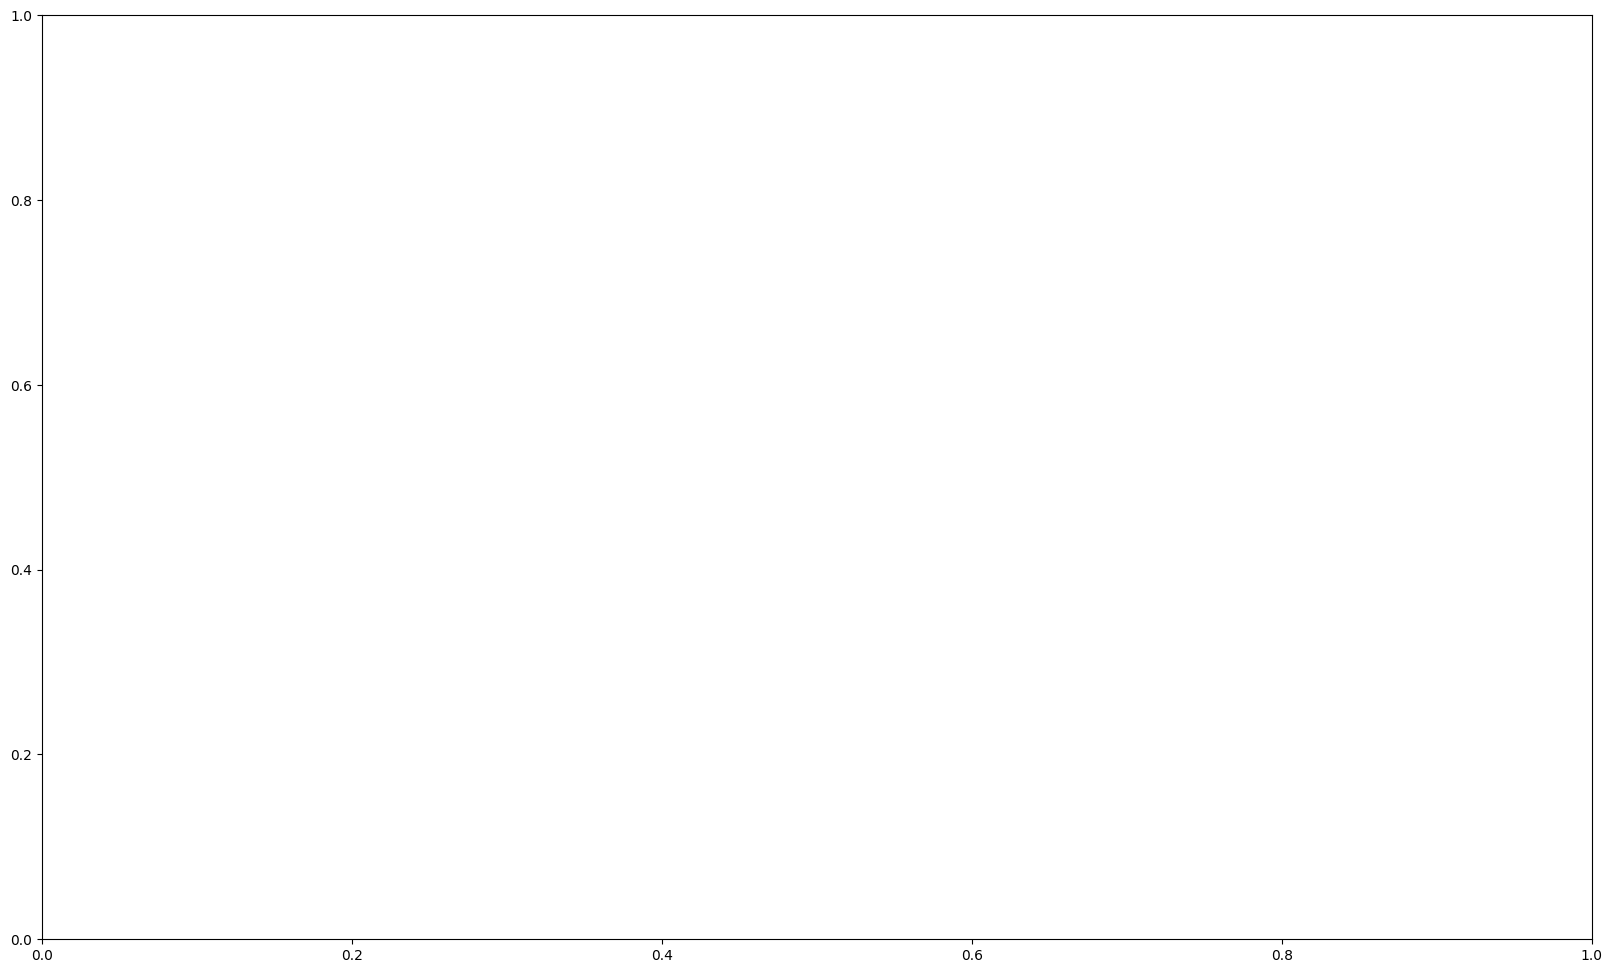

In [10]:
fig, ax = plt.subplots(figsize=(20, 12))
ax1 = utilities.plot_barh_graph((train["Target"].value_counts()/len(train)).tolist(),
                                 [f"Traget: {i}" for i in train["Target"].value_counts().index.tolist()],
                                  'Amount for each target label', 'target label', "GnBu_r", ax)
ax1.set_title("distribution of target label")

utilities.display_density_comparison(train, 'Course', 'Target')

# non significant
ax= utilities.plt_multiple_barh_repartition(train, "Target", "Nacionality")
ax.set_title(f"distribution of Nacionality for Target's classe")

# non significant
ax= utilities.plt_multiple_barh_repartition(train, "Target", "Educational special needs")

# ["Nacionality", "Educational special needs", "International"]
# ["Nacionality", "Educational special needs", "International", "Curricular units 1st sem (credited)", "Curricular units 2nd sem (credited)"]

# non significant
ax= utilities.plt_multiple_barh_repartition(train, "Target", "International")

ax= utilities.plt_multiple_barh_repartition(train, "Target", "Curricular units 1st sem (credited)")

ax= utilities.plt_multiple_barh_repartition(train, "Target", "Curricular units 2nd sem (credited)")

Nacionality as no significant info

No missing values

# we have a lot of value so we will try to reduce dim

{0: 'Dropout', 1: 'Enrolled', 2: 'Graduate'}
columns correlation inf to 0.01
 ['Educational special needs', 'International']


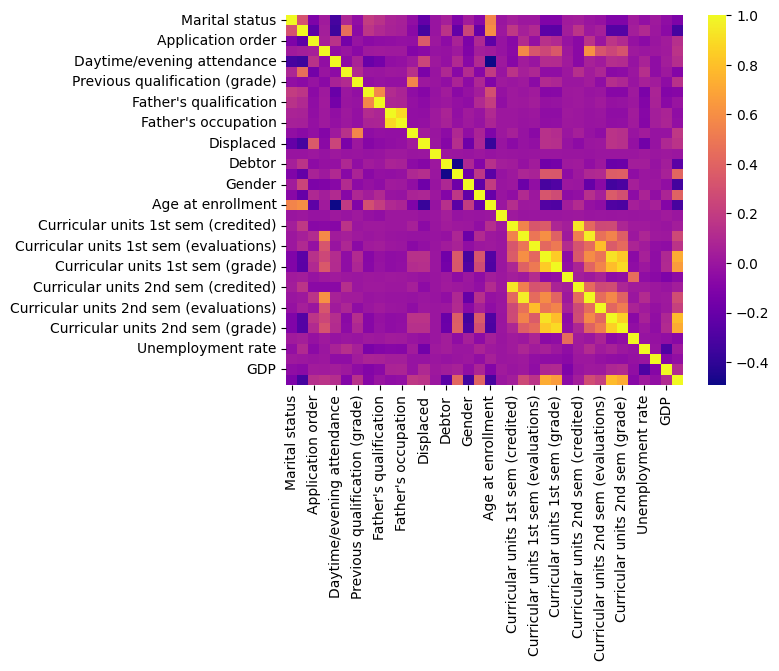

In [11]:
Id = test['id']
Target = train['Target']

df_train= train.drop(['id', 'Target', "Nacionality"], axis= 1)
df_test= test.drop(['id', "Nacionality"], axis= 1)

encode = LabelEncoder()

df_train['Target_encoded'] = encode.fit_transform(Target)

dict_target = dict(zip(encode.transform(encode.classes_), encode.classes_))
print(dict_target)
# see correlation
correlation = df_train.corr()

tresh = 0.01
print(f'columns correlation inf to {tresh}\n', [correlation.Target_encoded.index.tolist()[i] for i, values in enumerate(correlation.Target_encoded) if abs(values)<tresh])

sns.heatmap(correlation, cmap = 'plasma')
plt.show()

# Preprocess before train

In [24]:
train = pd.read_csv('/Users/avicenne/Documents/python/Project-github/Kaggle/playground-series-s4e6/train.csv')
test = pd.read_csv('/Users/avicenne/Documents/python/Project-github/Kaggle/playground-series-s4e6/test.csv')

Id = test['id']
Target = train['Target']

encode = LabelEncoder()
Encoded_target = encode.fit_transform(Target)

# save label
dict_target = dict(zip(encode.transform(encode.classes_), encode.classes_))

# Standard scaler
sc = StandardScaler()

mms = MinMaxScaler()

#drop_label= ["id", "Nacionality", "Educational special needs", "International", "Curricular units 1st sem (credited)", "Curricular units 2nd sem (credited)"]
drop_label= ["id", "Nacionality", "Educational special needs", "International"]
#drop_label= ["id"]

#df_train= sum_similar_col(train)
#df_test= sum_similar_col(test)

df_train = sc.fit_transform(train.drop(['Target']+drop_label, 
                                       axis= 1))

df_test = sc.transform(test.drop(drop_label, 
                                 axis= 1))


""" if we don't want to preprocess
df_train= train.drop(['Target']+drop_label, 
                                       axis= 1)
df_test= test.drop(drop_label, 
                             axis= 1)"""

df_train

array([[-0.25343684, -0.90242254, -0.52406561, ..., -0.15841825,
        -0.44910992,  0.93317583],
       [-0.25343684,  0.05668196, -0.52406561, ..., -0.15841825,
        -0.44910992,  0.93317583],
       [-0.25343684,  0.05668196,  0.28918253, ...,  1.7636745 ,
        -0.66357837, -0.37269756],
       ...,
       [ 8.80317976,  0.05668196, -0.52406561, ..., -0.79911583,
        -1.44996265, -1.34988173],
       [-0.25343684, -0.90242254,  1.10243066, ..., -1.47750151,
         0.98067968,  0.17807897],
       [-0.25343684, -0.90242254, -0.52406561, ...,  1.49985785,
         1.12365864, -1.76740587]])

# Split

In [25]:
x_train, x_val, y_train, y_val = train_test_split(df_train,
                                                  Encoded_target,
                                                  test_size = 0.3, random_state = 42)
x_train.shape

(53562, 33)

# First prediction

In [16]:
# preprocessing with StandardScaler and MinMaxScaler important
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(x_train, y_train)

pred = clf.predict(x_val)

accuracy_score(y_val, pred)

0.8217023871754661

In [18]:
# preprocessing with StandardScaler and MinMaxScaler not important

import xgboost as xgb
from xgboost import XGBClassifier

XGB = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

XGB.fit(x_train, y_train)

predictions_xgb = XGB.predict(x_val)

print("Accuracy : ",  accuracy_score(y_val, predictions_xgb))

# Utiliser la validation croisée pour évaluer la performance du modèle
scores = cross_val_score(XGB, x_train, y_train, cv=5, scoring='accuracy')
print("Cross-validation accuracy scores: ", scores)
print("Mean cross-validation accuracy: ", scores.mean())

Accuracy :  0.8347708660045304
Cross-validation accuracy scores:  [0.82152525 0.82199197 0.82178865 0.82804332 0.83103062]
Mean cross-validation accuracy:  0.8248759612169143


# Find best hyperparams cat

In [20]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint


def get_hyppars_(model, params, n_iter, cv, scoring, n_jobs,
                random_state, x_train, y_train, x_val, y_val):

    # Initialisation RandomizedSearchCV
    random_search = RandomizedSearchCV(estimator=model, param_distributions=params, 
                                       n_iter=n_iter, cv=cv,
                                       scoring=scoring, n_jobs=n_jobs, random_state=42)

    # Train
    random_search.fit(x_train, y_train)

    # Print
    print("Best parameters found using random_search: ", random_search.best_params_)
    print("Best accuracy score found during search using random_search: ", random_search.best_score_)

In [ ]:
"""from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

models = [CatBoostClassifier(verbose=0)]
params = [{
            'iterations': randint(80, 200),
            'learning_rate': uniform(0.1, 0.2),
            'depth': randint(1, 6)
                        }]

for i in range(len(models)):
    print('for :', models[i])
    get_hyppars_(models[i], params[i], n_iter = 15, cv=8, scoring = 'accuracy', n_jobs=-1,
                 random_state=0, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val)
    """

"from catboost import CatBoostClassifier\nfrom sklearn.model_selection import RandomizedSearchCV\nfrom scipy.stats import uniform, randint\n\nmodels = [CatBoostClassifier(verbose=0)]\nparams = [{\n            'iterations': randint(80, 200),\n            'learning_rate': uniform(0.1, 0.2),\n            'depth': randint(1, 6)\n                        }]\n\nfor i in range(len(models)):\n    print('for :', models[i])\n    get_hyppars_(models[i], params[i], n_iter = 15, cv=8, scoring = 'accuracy', n_jobs=-1,\n                 random_state=0, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val)\n    "

In [ ]:
"""from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

models = [XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)]
params = [{
        'n_estimators': randint(100, 2000),
        'learning_rate': uniform(0.1, 0.5),
        'max_depth': randint(1, 10)
    }]

for i in range(len(models)):
    print('for :', models[i])
    get_hyppars_(models[i], params[i], n_iter = 25, cv=10, scoring = 'accuracy', n_jobs=-1,
                 random_state=0, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val)
    """

"from catboost import CatBoostClassifier\nfrom sklearn.model_selection import RandomizedSearchCV\nfrom scipy.stats import uniform, randint\n\nmodels = [XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)]\nparams = [{\n        'n_estimators': randint(100, 2000),\n        'learning_rate': uniform(0.1, 0.5),\n        'max_depth': randint(1, 10)\n    }]\n\nfor i in range(len(models)):\n    print('for :', models[i])\n    get_hyppars_(models[i], params[i], n_iter = 25, cv=10, scoring = 'accuracy', n_jobs=-1,\n                 random_state=0, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val)\n    "

In [22]:
from catboost import CatBoostClassifier

#iterations=50, learning_rate=0.1, depth=3,random_seed=0, verbose=0
#iterations=285, learning_rate=0.11949697012050743, depth=3,random_seed=0, verbose=0

Cat = CatBoostClassifier(iterations=50, 
                         learning_rate=0.1, 
                         depth=3,random_seed=0, 
                         verbose=0)

Cat.fit(x_train, y_train)

pred_cat = Cat.predict(x_val)

print("Accuracy : ",  accuracy_score(y_val, pred_cat))

# Utiliser la validation croisée pour évaluer la performance du modèle
scores = cross_val_score(Cat, x_train, y_train, cv=5, scoring='accuracy')
print("Cross-validation accuracy scores: ", scores)
print("Mean cross-validation accuracy: ", scores.mean())

Accuracy :  0.8203955392925597
Cross-validation accuracy scores:  [0.813871   0.81125735 0.80955937 0.81301344 0.81600075]
Mean cross-validation accuracy:  0.8127403822190304


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc= RandomForestClassifier(n_estimators = 100)

rfc.fit(x_train, y_train)

predictions = rfc.predict(x_val)

print("accuracy : ",  accuracy_score(y_val, predictions))

cm = confusion_matrix(y_val, predictions)
sns.heatmap(cm,annot = True,fmt = ".1f")
plt.show()

In [29]:
lgbm= LGBMClassifier()

lgbm.fit(x_train, y_train)

predictions = lgbm.predict(x_val)

print("accuracy : ",  accuracy_score(y_val, predictions))

# Utiliser la validation croisée pour évaluer la performance du modèle
scores = cross_val_score(lgbm, x_train, y_train, cv=5, scoring='accuracy')
print("Cross-validation accuracy scores: ", scores)
print("Mean cross-validation accuracy: ", scores.mean())

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002851 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1363
[LightGBM] [Info] Number of data points in the train set: 53562, number of used features: 33
[LightGBM] [Info] Start training from score -1.106315
[LightGBM] [Info] Start training from score -1.628037
[LightGBM] [Info] Start training from score -0.748850
accuracy :  0.8362955218679212
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1346
[LightGBM] [Info] Number of data points in the train set: 42849, number of used features: 33
[LightGBM] [Info] Start training from score -1.106344
[LightGBM] [Info] Start training from score -1.

In [27]:
from lightgbm import LGBMClassifier

clf = LogisticRegression(max_iter=1000)
rfc = RandomForestClassifier(n_estimators=100, random_state=42)

xgb = XGBClassifier(random_state=42)
cat = CatBoostClassifier(verbose=False, random_state=42)
hgb = HistGradientBoostingClassifier(random_state=42)
lgb = LGBMClassifier()

bag = BaggingClassifier(estimator=XGBClassifier(random_state=42),
                        n_estimators=10, random_state=0).fit(x_train, y_train)

predictions_bag = bag.predict(x_val)

print("accuracy bag: ",  accuracy_score(y_val, predictions_bag))

# Utiliser la validation croisée pour évaluer la performance du modèle
scores = cross_val_score(bag, x_train, y_train, cv=5, scoring='accuracy')
print("Cross-validation accuracy scores: ", scores)
print("Mean cross-validation accuracy: ", scores.mean())

accuracy bag:  0.838212232096184
Cross-validation accuracy scores:  [0.82684589 0.82544572 0.82617625 0.82935026 0.83084391]
Mean cross-validation accuracy:  0.8277324068034293


In [ ]:
pred = bag.predict(df_test)

submission = pd.DataFrame({'id': Id,
                           'Target': [dict_target[p] for p in pred]})

# Save submission to a CSV file
submission.to_csv('submission.csv', index=False)

In [ ]:
"""from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier,VotingClassifier
from lightgbm import LGBMClassifier

clf = LogisticRegression(max_iter=1000)
rfc = RandomForestClassifier(n_estimators=100, random_state=42)

xgb = XGBClassifier(random_state=42)
cat = CatBoostClassifier(verbose=False, random_state=42)
hgb = HistGradientBoostingClassifier(random_state=42)
lgb = LGBMClassifier()

voting_boost = VotingClassifier(estimators=[
        ('xgb', xgb), ('hgb', hgb), ('lgb', lgb)], voting='soft')

voting_boost.fit(x_train, y_train)"""


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1363
[LightGBM] [Info] Number of data points in the train set: 53562, number of used features: 33
[LightGBM] [Info] Start training from score -1.106315
[LightGBM] [Info] Start training from score -1.628037
[LightGBM] [Info] Start training from score -0.748850


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_ra...
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('cat',
                              <catboost.core.CatBoostClassifier object at 0x7a095bccf730>),
                             ('hgb',
                              HistGradientBoostingClassifier(random_state=42)),
                             ('lgb', LGBMClassifier())],
                 voting='soft')

In [ ]:
"""predictions_boost = voting_boost.predict(x_val)

print("accuracy boost: ",  accuracy_score(y_val, predictions_boost))

# Utiliser la validation croisée pour évaluer la performance du modèle
scores = cross_val_score(voting_boost, x_train, y_train, cv=5, scoring='accuracy')
print("Cross-validation accuracy scores: ", scores)
print("Mean cross-validation accuracy: ", scores.mean())"""

accuracy boost:  0.837471684962537
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1346
[LightGBM] [Info] Number of data points in the train set: 42849, number of used features: 33
[LightGBM] [Info] Start training from score -1.106344
[LightGBM] [Info] Start training from score -1.628023
[LightGBM] [Info] Start training from score -0.748836
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1353
[LightGBM] [Info] Number of data points in the train set: 42849, number of used features: 33
[LightGBM] [Info] Start training from score -1.106344
[LightGBM] [Info] Start training from score

In [28]:
def submission(model, test, Id, dict_target):
    pred = model.predict(test)

    submission = pd.DataFrame({'id': Id,
                               'Target': [dict_target[p] for p in pred]})

    # Save submission to a CSV file
    submission.to_csv('submission.csv', index=False)
    
submission(bag, df_test, Id, dict_target)